In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from dataloader import CustomDataset
import Config
import torch
import utils
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import functional as F
from torch.nn import CrossEntropyLoss
import torchvision.transforms 
import matplotlib.pyplot as plt
import numpy as np
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils
import math
import sys
import time

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    # resizing all images
#     transforms.append(T.FixedSizeCrop(size=(976,976)))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

json_path = 'C:\\Users\\Jessica NT MCA\\Desktop\\MA_Abdelrahman\\Master Thesis Project\\Mask RCNN\\Dataset\\annotations.json'

# use our dataset and defined transformations
dataset = CustomDataset(root = Config.Dataset_dir, json_file=json_path, transform = get_transform(train=True))
dataset_val = CustomDataset(root = Config.Dataset_dir, json_file=json_path, transform = get_transform(train=False))
dataset_test = CustomDataset(root = Config.Dataset_dir, json_file=json_path, transform = get_transform(train=False))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)-1).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:2604])
dataset_val = torch.utils.data.Subset(dataset_val, indices[2604:-326])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-326:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True,
    collate_fn=utils.collate_fn)


# for i, (images, targets) in enumerate(data_loader):
#     plot_samples(images,targets[0]['masks'])


data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=16, shuffle=False,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False,
    collate_fn=utils.collate_fn)

device = Config.DEVICE

# dataset has two classes only - background and person
num_classes = 2

# get the model using the helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# train the model for 100 epochs
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    
    total_loss = 0

    for images, targets in metric_logger.log_every(data_loader, print_freq=50, header = header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses

#         # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    scheduler.step(total_loss)

    with torch.no_grad():
        n_threads = torch.get_num_threads()
        # FIXME remove this and make paste_masks_in_image run on the GPU
        torch.set_num_threads(1)
        cpu_device = torch.device("cpu")
        model.eval()
        metric_logger = utils.MetricLogger(delimiter="  ")
        header = 'Test:'

        coco = get_coco_api_from_dataset(data_loader_val.dataset)
        iou_types = _get_iou_types(model)
        coco_evaluator = CocoEvaluator(coco, iou_types)

        for image, targets in metric_logger.log_every(data_loader_val, 100, header = header):
            image = list(img.to(device) for img in image)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            torch.cuda.synchronize()
            model_time = time.time()
            outputs = model(image)

            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            model_time = time.time() - model_time

            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            evaluator_time = time.time()
            coco_evaluator.update(res)
            evaluator_time = time.time() - evaluator_time
            metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

        # gather the stats from all processes
        metric_logger.synchronize_between_processes()
        print("Averaged stats:", metric_logger)
        coco_evaluator.synchronize_between_processes()

        # accumulate predictions from all images
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
        torch.set_num_threads(n_threads)
        print(coco_evaluator)
        
torch.save(model, Config.MODEL_PATH)

Epoch: [0]  [  0/204]  eta: 0:12:24  lr: 0.005000  loss: 5.9672 (5.9672)  loss_classifier: 1.0685 (1.0685)  loss_box_reg: 0.1752 (0.1752)  loss_mask: 2.9485 (2.9485)  loss_objectness: 1.5671 (1.5671)  loss_rpn_box_reg: 0.2080 (0.2080)  time: 3.6503  data: 0.3251  max mem: 11398
Epoch: [0]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.7572 (1.0198)  loss_classifier: 0.0860 (0.1271)  loss_box_reg: 0.1852 (0.1711)  loss_mask: 0.3783 (0.5312)  loss_objectness: 0.0168 (0.0748)  loss_rpn_box_reg: 0.0854 (0.1156)  time: 1.5300  data: 0.3410  max mem: 11687
Epoch: [0]  [100/204]  eta: 0:02:39  lr: 0.005000  loss: 0.6150 (0.8479)  loss_classifier: 0.0669 (0.1018)  loss_box_reg: 0.1499 (0.1732)  loss_mask: 0.3060 (0.4309)  loss_objectness: 0.0104 (0.0448)  loss_rpn_box_reg: 0.0565 (0.0972)  time: 1.5253  data: 0.3374  max mem: 11688
Epoch: [0]  [150/204]  eta: 0:01:22  lr: 0.005000  loss: 0.5116 (0.7468)  loss_classifier: 0.0557 (0.0882)  loss_box_reg: 0.1283 (0.1607)  loss_mask: 0.2569 (0.377

Epoch: [2]  [  0/204]  eta: 0:05:12  lr: 0.005000  loss: 0.4390 (0.4390)  loss_classifier: 0.0454 (0.0454)  loss_box_reg: 0.1144 (0.1144)  loss_mask: 0.2132 (0.2132)  loss_objectness: 0.0043 (0.0043)  loss_rpn_box_reg: 0.0616 (0.0616)  time: 1.5339  data: 0.3291  max mem: 11724
Epoch: [2]  [ 50/204]  eta: 0:04:00  lr: 0.005000  loss: 0.3083 (0.3277)  loss_classifier: 0.0359 (0.0368)  loss_box_reg: 0.0771 (0.0822)  loss_mask: 0.1515 (0.1605)  loss_objectness: 0.0034 (0.0045)  loss_rpn_box_reg: 0.0285 (0.0438)  time: 1.5592  data: 0.3383  max mem: 11724
Epoch: [2]  [100/204]  eta: 0:02:42  lr: 0.005000  loss: 0.2941 (0.3145)  loss_classifier: 0.0334 (0.0353)  loss_box_reg: 0.0688 (0.0782)  loss_mask: 0.1451 (0.1557)  loss_objectness: 0.0038 (0.0042)  loss_rpn_box_reg: 0.0302 (0.0412)  time: 1.5548  data: 0.3295  max mem: 11724
Epoch: [2]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.3001 (0.3139)  loss_classifier: 0.0331 (0.0350)  loss_box_reg: 0.0753 (0.0783)  loss_mask: 0.1529 (0.156

Epoch: [4]  [  0/204]  eta: 0:05:16  lr: 0.005000  loss: 0.2197 (0.2197)  loss_classifier: 0.0218 (0.0218)  loss_box_reg: 0.0570 (0.0570)  loss_mask: 0.1137 (0.1137)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0245 (0.0245)  time: 1.5518  data: 0.3481  max mem: 11919
Epoch: [4]  [ 50/204]  eta: 0:04:00  lr: 0.005000  loss: 0.2627 (0.2594)  loss_classifier: 0.0297 (0.0280)  loss_box_reg: 0.0696 (0.0646)  loss_mask: 0.1287 (0.1337)  loss_objectness: 0.0029 (0.0031)  loss_rpn_box_reg: 0.0202 (0.0300)  time: 1.5696  data: 0.3437  max mem: 11919
Epoch: [4]  [100/204]  eta: 0:02:42  lr: 0.005000  loss: 0.2479 (0.2595)  loss_classifier: 0.0238 (0.0279)  loss_box_reg: 0.0557 (0.0646)  loss_mask: 0.1230 (0.1314)  loss_objectness: 0.0038 (0.0033)  loss_rpn_box_reg: 0.0264 (0.0323)  time: 1.5605  data: 0.3386  max mem: 12016
Epoch: [4]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.2368 (0.2556)  loss_classifier: 0.0255 (0.0274)  loss_box_reg: 0.0607 (0.0635)  loss_mask: 0.1220 (0.129

Epoch: [6]  [  0/204]  eta: 0:05:12  lr: 0.005000  loss: 0.1855 (0.1855)  loss_classifier: 0.0212 (0.0212)  loss_box_reg: 0.0421 (0.0421)  loss_mask: 0.1035 (0.1035)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0160 (0.0160)  time: 1.5339  data: 0.3511  max mem: 12016
Epoch: [6]  [ 50/204]  eta: 0:04:00  lr: 0.005000  loss: 0.2382 (0.2211)  loss_classifier: 0.0235 (0.0237)  loss_box_reg: 0.0603 (0.0546)  loss_mask: 0.1173 (0.1138)  loss_objectness: 0.0024 (0.0026)  loss_rpn_box_reg: 0.0262 (0.0265)  time: 1.5598  data: 0.3349  max mem: 12016
Epoch: [6]  [100/204]  eta: 0:02:42  lr: 0.005000  loss: 0.2356 (0.2276)  loss_classifier: 0.0234 (0.0239)  loss_box_reg: 0.0565 (0.0566)  loss_mask: 0.1145 (0.1144)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0333 (0.0300)  time: 1.5593  data: 0.3349  max mem: 12016
Epoch: [6]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.2032 (0.2266)  loss_classifier: 0.0218 (0.0240)  loss_box_reg: 0.0531 (0.0564)  loss_mask: 0.1037 (0.114

Epoch: [8]  [  0/204]  eta: 0:05:16  lr: 0.005000  loss: 0.2492 (0.2492)  loss_classifier: 0.0317 (0.0317)  loss_box_reg: 0.0652 (0.0652)  loss_mask: 0.1190 (0.1190)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0304 (0.0304)  time: 1.5498  data: 0.3281  max mem: 12016
Epoch: [8]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1898 (0.2043)  loss_classifier: 0.0206 (0.0212)  loss_box_reg: 0.0422 (0.0483)  loss_mask: 0.0972 (0.1035)  loss_objectness: 0.0014 (0.0025)  loss_rpn_box_reg: 0.0233 (0.0287)  time: 1.5630  data: 0.3435  max mem: 12016
Epoch: [8]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.2189 (0.2097)  loss_classifier: 0.0220 (0.0220)  loss_box_reg: 0.0536 (0.0515)  loss_mask: 0.1084 (0.1071)  loss_objectness: 0.0023 (0.0024)  loss_rpn_box_reg: 0.0213 (0.0267)  time: 1.5555  data: 0.3331  max mem: 12016
Epoch: [8]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.2090 (0.2095)  loss_classifier: 0.0209 (0.0216)  loss_box_reg: 0.0499 (0.0514)  loss_mask: 0.1049 (0.107

Epoch: [10]  [  0/204]  eta: 0:05:10  lr: 0.005000  loss: 0.1852 (0.1852)  loss_classifier: 0.0163 (0.0163)  loss_box_reg: 0.0528 (0.0528)  loss_mask: 0.1014 (0.1014)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0128 (0.0128)  time: 1.5210  data: 0.3092  max mem: 12016
Epoch: [10]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1833 (0.1883)  loss_classifier: 0.0177 (0.0189)  loss_box_reg: 0.0437 (0.0459)  loss_mask: 0.0960 (0.0988)  loss_objectness: 0.0014 (0.0020)  loss_rpn_box_reg: 0.0219 (0.0228)  time: 1.5544  data: 0.3388  max mem: 12016
Epoch: [10]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.2015 (0.1989)  loss_classifier: 0.0201 (0.0205)  loss_box_reg: 0.0488 (0.0491)  loss_mask: 0.0992 (0.1014)  loss_objectness: 0.0029 (0.0023)  loss_rpn_box_reg: 0.0228 (0.0256)  time: 1.5524  data: 0.3295  max mem: 12016
Epoch: [10]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.2036 (0.1998)  loss_classifier: 0.0187 (0.0207)  loss_box_reg: 0.0524 (0.0499)  loss_mask: 0.1097 (0

Epoch: [12]  [  0/204]  eta: 0:05:19  lr: 0.005000  loss: 0.1729 (0.1729)  loss_classifier: 0.0142 (0.0142)  loss_box_reg: 0.0480 (0.0480)  loss_mask: 0.0935 (0.0935)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 1.5648  data: 0.3511  max mem: 12169
Epoch: [12]  [ 50/204]  eta: 0:03:59  lr: 0.005000  loss: 0.1673 (0.1834)  loss_classifier: 0.0173 (0.0187)  loss_box_reg: 0.0420 (0.0445)  loss_mask: 0.0916 (0.0952)  loss_objectness: 0.0014 (0.0021)  loss_rpn_box_reg: 0.0199 (0.0229)  time: 1.5501  data: 0.3383  max mem: 12169
Epoch: [12]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1758 (0.1836)  loss_classifier: 0.0174 (0.0184)  loss_box_reg: 0.0443 (0.0442)  loss_mask: 0.0939 (0.0962)  loss_objectness: 0.0027 (0.0023)  loss_rpn_box_reg: 0.0218 (0.0225)  time: 1.5547  data: 0.3328  max mem: 12169
Epoch: [12]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.1890 (0.1856)  loss_classifier: 0.0196 (0.0188)  loss_box_reg: 0.0429 (0.0440)  loss_mask: 0.0939 (0

Epoch: [14]  [  0/204]  eta: 0:05:16  lr: 0.005000  loss: 0.1809 (0.1809)  loss_classifier: 0.0189 (0.0189)  loss_box_reg: 0.0437 (0.0437)  loss_mask: 0.0833 (0.0833)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0328 (0.0328)  time: 1.5528  data: 0.3231  max mem: 12169
Epoch: [14]  [ 50/204]  eta: 0:04:00  lr: 0.005000  loss: 0.1709 (0.1813)  loss_classifier: 0.0169 (0.0185)  loss_box_reg: 0.0393 (0.0427)  loss_mask: 0.0942 (0.0950)  loss_objectness: 0.0019 (0.0020)  loss_rpn_box_reg: 0.0195 (0.0231)  time: 1.5682  data: 0.3495  max mem: 12169
Epoch: [14]  [100/204]  eta: 0:02:42  lr: 0.005000  loss: 0.1708 (0.1819)  loss_classifier: 0.0175 (0.0183)  loss_box_reg: 0.0395 (0.0427)  loss_mask: 0.0881 (0.0952)  loss_objectness: 0.0019 (0.0021)  loss_rpn_box_reg: 0.0202 (0.0236)  time: 1.5533  data: 0.3311  max mem: 12169
Epoch: [14]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.1742 (0.1798)  loss_classifier: 0.0158 (0.0179)  loss_box_reg: 0.0419 (0.0427)  loss_mask: 0.0993 (0

Epoch: [16]  [  0/204]  eta: 0:05:35  lr: 0.005000  loss: 0.1929 (0.1929)  loss_classifier: 0.0181 (0.0181)  loss_box_reg: 0.0463 (0.0463)  loss_mask: 0.1065 (0.1065)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0203 (0.0203)  time: 1.6426  data: 0.4368  max mem: 12169
Epoch: [16]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1627 (0.1781)  loss_classifier: 0.0154 (0.0178)  loss_box_reg: 0.0374 (0.0431)  loss_mask: 0.0904 (0.0955)  loss_objectness: 0.0015 (0.0023)  loss_rpn_box_reg: 0.0155 (0.0195)  time: 1.5545  data: 0.3450  max mem: 12169
Epoch: [16]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1624 (0.1753)  loss_classifier: 0.0160 (0.0177)  loss_box_reg: 0.0369 (0.0422)  loss_mask: 0.0884 (0.0937)  loss_objectness: 0.0017 (0.0021)  loss_rpn_box_reg: 0.0179 (0.0196)  time: 1.5516  data: 0.3354  max mem: 12169
Epoch: [16]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1670 (0.1749)  loss_classifier: 0.0154 (0.0173)  loss_box_reg: 0.0366 (0.0416)  loss_mask: 0.0926 (0

Epoch: [18]  [  0/204]  eta: 0:05:14  lr: 0.005000  loss: 0.1341 (0.1341)  loss_classifier: 0.0141 (0.0141)  loss_box_reg: 0.0308 (0.0308)  loss_mask: 0.0712 (0.0712)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0156 (0.0156)  time: 1.5429  data: 0.3301  max mem: 12169
Epoch: [18]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1759 (0.1725)  loss_classifier: 0.0187 (0.0179)  loss_box_reg: 0.0453 (0.0437)  loss_mask: 0.0889 (0.0908)  loss_objectness: 0.0014 (0.0021)  loss_rpn_box_reg: 0.0185 (0.0180)  time: 1.5530  data: 0.3327  max mem: 12169
Epoch: [18]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1579 (0.1748)  loss_classifier: 0.0158 (0.0177)  loss_box_reg: 0.0398 (0.0438)  loss_mask: 0.0865 (0.0927)  loss_objectness: 0.0015 (0.0020)  loss_rpn_box_reg: 0.0146 (0.0186)  time: 1.5618  data: 0.3339  max mem: 12169
Epoch: [18]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.1610 (0.1710)  loss_classifier: 0.0151 (0.0171)  loss_box_reg: 0.0337 (0.0418)  loss_mask: 0.0868 (0

Epoch: [20]  [  0/204]  eta: 0:05:16  lr: 0.005000  loss: 0.1716 (0.1716)  loss_classifier: 0.0174 (0.0174)  loss_box_reg: 0.0426 (0.0426)  loss_mask: 0.0929 (0.0929)  loss_objectness: 0.0043 (0.0043)  loss_rpn_box_reg: 0.0145 (0.0145)  time: 1.5499  data: 0.3501  max mem: 12299
Epoch: [20]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1532 (0.1604)  loss_classifier: 0.0155 (0.0160)  loss_box_reg: 0.0386 (0.0368)  loss_mask: 0.0883 (0.0861)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0163 (0.0197)  time: 1.5636  data: 0.3492  max mem: 12299
Epoch: [20]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1553 (0.1641)  loss_classifier: 0.0138 (0.0164)  loss_box_reg: 0.0361 (0.0389)  loss_mask: 0.0841 (0.0869)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0183 (0.0198)  time: 1.5501  data: 0.3348  max mem: 12299
Epoch: [20]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1576 (0.1645)  loss_classifier: 0.0149 (0.0164)  loss_box_reg: 0.0409 (0.0391)  loss_mask: 0.0863 (0

Epoch: [22]  [  0/204]  eta: 0:05:21  lr: 0.005000  loss: 0.1894 (0.1894)  loss_classifier: 0.0210 (0.0210)  loss_box_reg: 0.0586 (0.0586)  loss_mask: 0.0959 (0.0959)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.5741  data: 0.3272  max mem: 12299
Epoch: [22]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1567 (0.1600)  loss_classifier: 0.0161 (0.0158)  loss_box_reg: 0.0374 (0.0367)  loss_mask: 0.0865 (0.0877)  loss_objectness: 0.0017 (0.0018)  loss_rpn_box_reg: 0.0141 (0.0180)  time: 1.5472  data: 0.3327  max mem: 12299
Epoch: [22]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1546 (0.1632)  loss_classifier: 0.0156 (0.0161)  loss_box_reg: 0.0367 (0.0377)  loss_mask: 0.0857 (0.0884)  loss_objectness: 0.0014 (0.0017)  loss_rpn_box_reg: 0.0166 (0.0193)  time: 1.5604  data: 0.3455  max mem: 12299
Epoch: [22]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1653 (0.1629)  loss_classifier: 0.0178 (0.0162)  loss_box_reg: 0.0374 (0.0379)  loss_mask: 0.0865 (0

Epoch: [24]  [  0/204]  eta: 0:05:01  lr: 0.005000  loss: 0.1775 (0.1775)  loss_classifier: 0.0111 (0.0111)  loss_box_reg: 0.0345 (0.0345)  loss_mask: 0.1031 (0.1031)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0256 (0.0256)  time: 1.4770  data: 0.3152  max mem: 12299
Epoch: [24]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1562 (0.1544)  loss_classifier: 0.0155 (0.0150)  loss_box_reg: 0.0340 (0.0356)  loss_mask: 0.0812 (0.0837)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0154 (0.0183)  time: 1.5635  data: 0.3419  max mem: 12299
Epoch: [24]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1464 (0.1530)  loss_classifier: 0.0151 (0.0154)  loss_box_reg: 0.0334 (0.0356)  loss_mask: 0.0825 (0.0838)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0150 (0.0166)  time: 1.5639  data: 0.3368  max mem: 12299
Epoch: [24]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.1578 (0.1556)  loss_classifier: 0.0144 (0.0155)  loss_box_reg: 0.0331 (0.0358)  loss_mask: 0.0822 (0

Epoch: [26]  [  0/204]  eta: 0:05:13  lr: 0.005000  loss: 0.1926 (0.1926)  loss_classifier: 0.0260 (0.0260)  loss_box_reg: 0.0541 (0.0541)  loss_mask: 0.1003 (0.1003)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 1.5378  data: 0.3361  max mem: 12299
Epoch: [26]  [ 50/204]  eta: 0:03:59  lr: 0.005000  loss: 0.1599 (0.1586)  loss_classifier: 0.0136 (0.0147)  loss_box_reg: 0.0342 (0.0360)  loss_mask: 0.0863 (0.0861)  loss_objectness: 0.0017 (0.0018)  loss_rpn_box_reg: 0.0133 (0.0200)  time: 1.5600  data: 0.3430  max mem: 12299
Epoch: [26]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1398 (0.1551)  loss_classifier: 0.0135 (0.0144)  loss_box_reg: 0.0310 (0.0347)  loss_mask: 0.0790 (0.0845)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0122 (0.0197)  time: 1.5455  data: 0.3329  max mem: 12299
Epoch: [26]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1552 (0.1554)  loss_classifier: 0.0154 (0.0147)  loss_box_reg: 0.0346 (0.0352)  loss_mask: 0.0823 (0

Epoch: [28]  [  0/204]  eta: 0:05:07  lr: 0.005000  loss: 0.1622 (0.1622)  loss_classifier: 0.0170 (0.0170)  loss_box_reg: 0.0446 (0.0446)  loss_mask: 0.0972 (0.0972)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 1.5060  data: 0.3211  max mem: 12299
Epoch: [28]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1534 (0.1529)  loss_classifier: 0.0148 (0.0148)  loss_box_reg: 0.0361 (0.0342)  loss_mask: 0.0848 (0.0813)  loss_objectness: 0.0011 (0.0015)  loss_rpn_box_reg: 0.0163 (0.0211)  time: 1.5667  data: 0.3409  max mem: 12299
Epoch: [28]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1364 (0.1480)  loss_classifier: 0.0134 (0.0144)  loss_box_reg: 0.0302 (0.0328)  loss_mask: 0.0779 (0.0802)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0136 (0.0190)  time: 1.5468  data: 0.3321  max mem: 12299
Epoch: [28]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1446 (0.1496)  loss_classifier: 0.0141 (0.0145)  loss_box_reg: 0.0326 (0.0333)  loss_mask: 0.0821 (0

Epoch: [30]  [  0/204]  eta: 0:05:05  lr: 0.005000  loss: 0.1505 (0.1505)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0339 (0.0339)  loss_mask: 0.0884 (0.0884)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 1.4970  data: 0.3172  max mem: 12299
Epoch: [30]  [ 50/204]  eta: 0:03:59  lr: 0.005000  loss: 0.1380 (0.1492)  loss_classifier: 0.0134 (0.0149)  loss_box_reg: 0.0327 (0.0353)  loss_mask: 0.0798 (0.0820)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0117 (0.0155)  time: 1.5452  data: 0.3297  max mem: 12299
Epoch: [30]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1413 (0.1496)  loss_classifier: 0.0130 (0.0144)  loss_box_reg: 0.0324 (0.0341)  loss_mask: 0.0761 (0.0809)  loss_objectness: 0.0019 (0.0018)  loss_rpn_box_reg: 0.0198 (0.0185)  time: 1.5567  data: 0.3355  max mem: 12299
Epoch: [30]  [150/204]  eta: 0:01:24  lr: 0.005000  loss: 0.1401 (0.1478)  loss_classifier: 0.0138 (0.0141)  loss_box_reg: 0.0330 (0.0337)  loss_mask: 0.0790 (0

Epoch: [32]  [  0/204]  eta: 0:05:17  lr: 0.005000  loss: 0.1823 (0.1823)  loss_classifier: 0.0119 (0.0119)  loss_box_reg: 0.0382 (0.0382)  loss_mask: 0.0975 (0.0975)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0339 (0.0339)  time: 1.5568  data: 0.3760  max mem: 12299
Epoch: [32]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1565 (0.1512)  loss_classifier: 0.0152 (0.0145)  loss_box_reg: 0.0364 (0.0348)  loss_mask: 0.0812 (0.0804)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0171 (0.0200)  time: 1.5561  data: 0.3333  max mem: 12299
Epoch: [32]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1392 (0.1468)  loss_classifier: 0.0134 (0.0142)  loss_box_reg: 0.0323 (0.0340)  loss_mask: 0.0784 (0.0798)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0100 (0.0171)  time: 1.5561  data: 0.3350  max mem: 12299
Epoch: [32]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1517 (0.1480)  loss_classifier: 0.0148 (0.0143)  loss_box_reg: 0.0356 (0.0344)  loss_mask: 0.0792 (0

Epoch: [34]  [  0/204]  eta: 0:05:12  lr: 0.005000  loss: 0.1689 (0.1689)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0294 (0.0294)  loss_mask: 0.0736 (0.0736)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0500 (0.0500)  time: 1.5309  data: 0.3221  max mem: 12299
Epoch: [34]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1416 (0.1450)  loss_classifier: 0.0131 (0.0137)  loss_box_reg: 0.0320 (0.0337)  loss_mask: 0.0806 (0.0799)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0109 (0.0161)  time: 1.5460  data: 0.3280  max mem: 12299
Epoch: [34]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1445 (0.1455)  loss_classifier: 0.0135 (0.0137)  loss_box_reg: 0.0338 (0.0332)  loss_mask: 0.0787 (0.0796)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0135 (0.0172)  time: 1.5600  data: 0.3400  max mem: 12299
Epoch: [34]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1354 (0.1461)  loss_classifier: 0.0130 (0.0137)  loss_box_reg: 0.0296 (0.0327)  loss_mask: 0.0751 (0

Epoch: [36]  [  0/204]  eta: 0:05:10  lr: 0.005000  loss: 0.1195 (0.1195)  loss_classifier: 0.0125 (0.0125)  loss_box_reg: 0.0263 (0.0263)  loss_mask: 0.0645 (0.0645)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0156 (0.0156)  time: 1.5230  data: 0.3162  max mem: 12299
Epoch: [36]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1412 (0.1435)  loss_classifier: 0.0135 (0.0136)  loss_box_reg: 0.0313 (0.0335)  loss_mask: 0.0791 (0.0799)  loss_objectness: 0.0015 (0.0016)  loss_rpn_box_reg: 0.0130 (0.0149)  time: 1.5560  data: 0.3417  max mem: 12299
Epoch: [36]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1343 (0.1404)  loss_classifier: 0.0127 (0.0134)  loss_box_reg: 0.0275 (0.0319)  loss_mask: 0.0750 (0.0782)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0138 (0.0153)  time: 1.5623  data: 0.3395  max mem: 12299
Epoch: [36]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1356 (0.1412)  loss_classifier: 0.0138 (0.0134)  loss_box_reg: 0.0320 (0.0314)  loss_mask: 0.0779 (0

Epoch: [38]  [  0/204]  eta: 0:05:08  lr: 0.005000  loss: 0.1315 (0.1315)  loss_classifier: 0.0149 (0.0149)  loss_box_reg: 0.0300 (0.0300)  loss_mask: 0.0749 (0.0749)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 1.5100  data: 0.3122  max mem: 12299
Epoch: [38]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1385 (0.1347)  loss_classifier: 0.0130 (0.0131)  loss_box_reg: 0.0303 (0.0297)  loss_mask: 0.0763 (0.0750)  loss_objectness: 0.0016 (0.0015)  loss_rpn_box_reg: 0.0127 (0.0154)  time: 1.5538  data: 0.3343  max mem: 12299
Epoch: [38]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1455 (0.1381)  loss_classifier: 0.0126 (0.0132)  loss_box_reg: 0.0323 (0.0302)  loss_mask: 0.0812 (0.0767)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0106 (0.0165)  time: 1.5443  data: 0.3291  max mem: 12299
Epoch: [38]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1307 (0.1394)  loss_classifier: 0.0131 (0.0135)  loss_box_reg: 0.0280 (0.0307)  loss_mask: 0.0754 (0

Epoch: [40]  [  0/204]  eta: 0:04:55  lr: 0.005000  loss: 0.0898 (0.0898)  loss_classifier: 0.0071 (0.0071)  loss_box_reg: 0.0150 (0.0150)  loss_mask: 0.0619 (0.0619)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 1.4482  data: 0.2942  max mem: 12299
Epoch: [40]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1425 (0.1358)  loss_classifier: 0.0121 (0.0127)  loss_box_reg: 0.0288 (0.0299)  loss_mask: 0.0752 (0.0749)  loss_objectness: 0.0020 (0.0016)  loss_rpn_box_reg: 0.0139 (0.0167)  time: 1.5516  data: 0.3379  max mem: 12299
Epoch: [40]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1414 (0.1379)  loss_classifier: 0.0141 (0.0132)  loss_box_reg: 0.0304 (0.0304)  loss_mask: 0.0791 (0.0754)  loss_objectness: 0.0015 (0.0016)  loss_rpn_box_reg: 0.0165 (0.0173)  time: 1.5465  data: 0.3310  max mem: 12299
Epoch: [40]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1223 (0.1379)  loss_classifier: 0.0128 (0.0132)  loss_box_reg: 0.0252 (0.0304)  loss_mask: 0.0718 (0

Epoch: [42]  [  0/204]  eta: 0:05:14  lr: 0.005000  loss: 0.1352 (0.1352)  loss_classifier: 0.0133 (0.0133)  loss_box_reg: 0.0339 (0.0339)  loss_mask: 0.0719 (0.0719)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 1.5418  data: 0.3241  max mem: 12299
Epoch: [42]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1327 (0.1331)  loss_classifier: 0.0129 (0.0128)  loss_box_reg: 0.0274 (0.0292)  loss_mask: 0.0747 (0.0750)  loss_objectness: 0.0011 (0.0015)  loss_rpn_box_reg: 0.0166 (0.0146)  time: 1.5506  data: 0.3383  max mem: 12299
Epoch: [42]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1292 (0.1346)  loss_classifier: 0.0127 (0.0131)  loss_box_reg: 0.0265 (0.0302)  loss_mask: 0.0742 (0.0755)  loss_objectness: 0.0010 (0.0015)  loss_rpn_box_reg: 0.0112 (0.0143)  time: 1.5527  data: 0.3373  max mem: 12299
Epoch: [42]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1261 (0.1349)  loss_classifier: 0.0113 (0.0128)  loss_box_reg: 0.0252 (0.0291)  loss_mask: 0.0699 (0

Epoch: [44]  [  0/204]  eta: 0:05:17  lr: 0.005000  loss: 0.1546 (0.1546)  loss_classifier: 0.0164 (0.0164)  loss_box_reg: 0.0415 (0.0415)  loss_mask: 0.0759 (0.0759)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0192 (0.0192)  time: 1.5548  data: 0.3191  max mem: 12299
Epoch: [44]  [ 50/204]  eta: 0:04:00  lr: 0.005000  loss: 0.1286 (0.1303)  loss_classifier: 0.0128 (0.0127)  loss_box_reg: 0.0283 (0.0292)  loss_mask: 0.0717 (0.0722)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0148 (0.0147)  time: 1.5538  data: 0.3326  max mem: 12299
Epoch: [44]  [100/204]  eta: 0:02:42  lr: 0.005000  loss: 0.1254 (0.1305)  loss_classifier: 0.0119 (0.0125)  loss_box_reg: 0.0296 (0.0290)  loss_mask: 0.0691 (0.0724)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0136 (0.0151)  time: 1.5569  data: 0.3403  max mem: 12299
Epoch: [44]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1366 (0.1315)  loss_classifier: 0.0135 (0.0127)  loss_box_reg: 0.0280 (0.0293)  loss_mask: 0.0747 (0

Epoch: [46]  [  0/204]  eta: 0:05:10  lr: 0.005000  loss: 0.1297 (0.1297)  loss_classifier: 0.0141 (0.0141)  loss_box_reg: 0.0323 (0.0323)  loss_mask: 0.0772 (0.0772)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 1.5209  data: 0.3181  max mem: 12299
Epoch: [46]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1297 (0.1256)  loss_classifier: 0.0113 (0.0112)  loss_box_reg: 0.0261 (0.0267)  loss_mask: 0.0701 (0.0721)  loss_objectness: 0.0018 (0.0015)  loss_rpn_box_reg: 0.0139 (0.0141)  time: 1.5537  data: 0.3403  max mem: 12299
Epoch: [46]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1274 (0.1289)  loss_classifier: 0.0131 (0.0117)  loss_box_reg: 0.0280 (0.0273)  loss_mask: 0.0718 (0.0728)  loss_objectness: 0.0016 (0.0015)  loss_rpn_box_reg: 0.0121 (0.0156)  time: 1.5406  data: 0.3249  max mem: 12299
Epoch: [46]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1328 (0.1314)  loss_classifier: 0.0125 (0.0123)  loss_box_reg: 0.0288 (0.0284)  loss_mask: 0.0749 (0

Epoch: [48]  [  0/204]  eta: 0:05:16  lr: 0.005000  loss: 0.1589 (0.1589)  loss_classifier: 0.0140 (0.0140)  loss_box_reg: 0.0323 (0.0323)  loss_mask: 0.0732 (0.0732)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0359 (0.0359)  time: 1.5518  data: 0.3231  max mem: 12299
Epoch: [48]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1309 (0.1295)  loss_classifier: 0.0108 (0.0118)  loss_box_reg: 0.0291 (0.0275)  loss_mask: 0.0677 (0.0709)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0133 (0.0180)  time: 1.5419  data: 0.3297  max mem: 12299
Epoch: [48]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1226 (0.1273)  loss_classifier: 0.0116 (0.0117)  loss_box_reg: 0.0261 (0.0269)  loss_mask: 0.0739 (0.0716)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0105 (0.0157)  time: 1.5468  data: 0.3318  max mem: 12299
Epoch: [48]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1200 (0.1290)  loss_classifier: 0.0120 (0.0119)  loss_box_reg: 0.0272 (0.0277)  loss_mask: 0.0713 (0

Epoch: [50]  [  0/204]  eta: 0:05:17  lr: 0.005000  loss: 0.1121 (0.1121)  loss_classifier: 0.0094 (0.0094)  loss_box_reg: 0.0211 (0.0211)  loss_mask: 0.0738 (0.0738)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 1.5541  data: 0.3810  max mem: 12299
Epoch: [50]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1203 (0.1239)  loss_classifier: 0.0104 (0.0114)  loss_box_reg: 0.0225 (0.0263)  loss_mask: 0.0688 (0.0705)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0124 (0.0140)  time: 1.5450  data: 0.3357  max mem: 12299
Epoch: [50]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1317 (0.1257)  loss_classifier: 0.0119 (0.0113)  loss_box_reg: 0.0278 (0.0256)  loss_mask: 0.0697 (0.0702)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0162 (0.0169)  time: 1.5623  data: 0.3395  max mem: 12299
Epoch: [50]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1285 (0.1268)  loss_classifier: 0.0119 (0.0114)  loss_box_reg: 0.0300 (0.0262)  loss_mask: 0.0728 (0

Epoch: [52]  [  0/204]  eta: 0:05:25  lr: 0.005000  loss: 0.1277 (0.1277)  loss_classifier: 0.0137 (0.0137)  loss_box_reg: 0.0281 (0.0281)  loss_mask: 0.0620 (0.0620)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0215 (0.0215)  time: 1.5953  data: 0.3551  max mem: 12299
Epoch: [52]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1212 (0.1255)  loss_classifier: 0.0111 (0.0118)  loss_box_reg: 0.0259 (0.0267)  loss_mask: 0.0674 (0.0707)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0108 (0.0148)  time: 1.5495  data: 0.3371  max mem: 12299
Epoch: [52]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1242 (0.1243)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0255 (0.0258)  loss_mask: 0.0698 (0.0704)  loss_objectness: 0.0017 (0.0018)  loss_rpn_box_reg: 0.0088 (0.0147)  time: 1.5389  data: 0.3278  max mem: 12299
Epoch: [52]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1278 (0.1260)  loss_classifier: 0.0113 (0.0117)  loss_box_reg: 0.0243 (0.0262)  loss_mask: 0.0725 (0

Epoch: [54]  [  0/204]  eta: 0:05:15  lr: 0.005000  loss: 0.1416 (0.1416)  loss_classifier: 0.0143 (0.0143)  loss_box_reg: 0.0379 (0.0379)  loss_mask: 0.0747 (0.0747)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0121 (0.0121)  time: 1.5449  data: 0.3201  max mem: 12299
Epoch: [54]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1212 (0.1227)  loss_classifier: 0.0101 (0.0112)  loss_box_reg: 0.0255 (0.0250)  loss_mask: 0.0686 (0.0691)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0155 (0.0158)  time: 1.5442  data: 0.3365  max mem: 12299
Epoch: [54]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1227 (0.1295)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0262 (0.0267)  loss_mask: 0.0714 (0.0707)  loss_objectness: 0.0009 (0.0016)  loss_rpn_box_reg: 0.0140 (0.0189)  time: 1.5509  data: 0.3324  max mem: 12299
Epoch: [54]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1195 (0.1270)  loss_classifier: 0.0108 (0.0114)  loss_box_reg: 0.0241 (0.0259)  loss_mask: 0.0695 (0

Epoch: [56]  [  0/204]  eta: 0:05:20  lr: 0.005000  loss: 0.1325 (0.1325)  loss_classifier: 0.0149 (0.0149)  loss_box_reg: 0.0338 (0.0338)  loss_mask: 0.0744 (0.0744)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 1.5728  data: 0.3401  max mem: 12299
Epoch: [56]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1255 (0.1245)  loss_classifier: 0.0107 (0.0109)  loss_box_reg: 0.0252 (0.0256)  loss_mask: 0.0739 (0.0713)  loss_objectness: 0.0020 (0.0018)  loss_rpn_box_reg: 0.0132 (0.0149)  time: 1.5369  data: 0.3313  max mem: 12299
Epoch: [56]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1194 (0.1236)  loss_classifier: 0.0105 (0.0112)  loss_box_reg: 0.0258 (0.0258)  loss_mask: 0.0720 (0.0708)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0129 (0.0142)  time: 1.5542  data: 0.3381  max mem: 12299
Epoch: [56]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1123 (0.1231)  loss_classifier: 0.0116 (0.0113)  loss_box_reg: 0.0225 (0.0255)  loss_mask: 0.0663 (0

Epoch: [58]  [  0/204]  eta: 0:05:23  lr: 0.005000  loss: 0.1135 (0.1135)  loss_classifier: 0.0114 (0.0114)  loss_box_reg: 0.0247 (0.0247)  loss_mask: 0.0699 (0.0699)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 1.5878  data: 0.3830  max mem: 12299
Epoch: [58]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1223 (0.1162)  loss_classifier: 0.0113 (0.0104)  loss_box_reg: 0.0239 (0.0234)  loss_mask: 0.0679 (0.0675)  loss_objectness: 0.0012 (0.0014)  loss_rpn_box_reg: 0.0133 (0.0135)  time: 1.5505  data: 0.3347  max mem: 12299
Epoch: [58]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1077 (0.1162)  loss_classifier: 0.0095 (0.0105)  loss_box_reg: 0.0208 (0.0234)  loss_mask: 0.0638 (0.0671)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0108 (0.0138)  time: 1.5531  data: 0.3402  max mem: 12299
Epoch: [58]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1224 (0.1201)  loss_classifier: 0.0109 (0.0108)  loss_box_reg: 0.0259 (0.0242)  loss_mask: 0.0686 (0

Epoch: [60]  [  0/204]  eta: 0:05:06  lr: 0.005000  loss: 0.1184 (0.1184)  loss_classifier: 0.0115 (0.0115)  loss_box_reg: 0.0225 (0.0225)  loss_mask: 0.0704 (0.0704)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 1.5030  data: 0.3182  max mem: 12299
Epoch: [60]  [ 50/204]  eta: 0:03:59  lr: 0.005000  loss: 0.1135 (0.1217)  loss_classifier: 0.0107 (0.0115)  loss_box_reg: 0.0237 (0.0252)  loss_mask: 0.0667 (0.0686)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0078 (0.0150)  time: 1.5520  data: 0.3379  max mem: 12299
Epoch: [60]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1278 (0.1179)  loss_classifier: 0.0106 (0.0110)  loss_box_reg: 0.0234 (0.0241)  loss_mask: 0.0697 (0.0683)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0092 (0.0131)  time: 1.5472  data: 0.3354  max mem: 12299
Epoch: [60]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1132 (0.1183)  loss_classifier: 0.0096 (0.0109)  loss_box_reg: 0.0211 (0.0240)  loss_mask: 0.0684 (0

Epoch: [62]  [  0/204]  eta: 0:05:06  lr: 0.005000  loss: 0.1251 (0.1251)  loss_classifier: 0.0104 (0.0104)  loss_box_reg: 0.0241 (0.0241)  loss_mask: 0.0751 (0.0751)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 1.5043  data: 0.3142  max mem: 12299
Epoch: [62]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1176 (0.1188)  loss_classifier: 0.0103 (0.0106)  loss_box_reg: 0.0228 (0.0239)  loss_mask: 0.0682 (0.0683)  loss_objectness: 0.0014 (0.0016)  loss_rpn_box_reg: 0.0103 (0.0145)  time: 1.5501  data: 0.3408  max mem: 12299
Epoch: [62]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1206 (0.1190)  loss_classifier: 0.0104 (0.0108)  loss_box_reg: 0.0250 (0.0242)  loss_mask: 0.0710 (0.0684)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0105 (0.0142)  time: 1.5521  data: 0.3374  max mem: 12299
Epoch: [62]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1159 (0.1192)  loss_classifier: 0.0112 (0.0108)  loss_box_reg: 0.0265 (0.0247)  loss_mask: 0.0676 (0

Epoch: [64]  [  0/204]  eta: 0:05:09  lr: 0.005000  loss: 0.0996 (0.0996)  loss_classifier: 0.0102 (0.0102)  loss_box_reg: 0.0215 (0.0215)  loss_mask: 0.0612 (0.0612)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 1.5180  data: 0.3152  max mem: 12299
Epoch: [64]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1141 (0.1188)  loss_classifier: 0.0106 (0.0110)  loss_box_reg: 0.0217 (0.0240)  loss_mask: 0.0684 (0.0686)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0108 (0.0136)  time: 1.5455  data: 0.3431  max mem: 12299
Epoch: [64]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1114 (0.1147)  loss_classifier: 0.0111 (0.0107)  loss_box_reg: 0.0232 (0.0233)  loss_mask: 0.0681 (0.0668)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0092 (0.0125)  time: 1.5524  data: 0.3328  max mem: 12299
Epoch: [64]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1197 (0.1155)  loss_classifier: 0.0092 (0.0104)  loss_box_reg: 0.0214 (0.0228)  loss_mask: 0.0663 (0

Epoch: [66]  [  0/204]  eta: 0:05:06  lr: 0.005000  loss: 0.0997 (0.0997)  loss_classifier: 0.0091 (0.0091)  loss_box_reg: 0.0166 (0.0166)  loss_mask: 0.0624 (0.0624)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 1.5020  data: 0.3241  max mem: 12299
Epoch: [66]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1048 (0.1120)  loss_classifier: 0.0098 (0.0100)  loss_box_reg: 0.0224 (0.0221)  loss_mask: 0.0652 (0.0666)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0094 (0.0119)  time: 1.5416  data: 0.3339  max mem: 12299
Epoch: [66]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1165 (0.1152)  loss_classifier: 0.0105 (0.0103)  loss_box_reg: 0.0222 (0.0229)  loss_mask: 0.0670 (0.0674)  loss_objectness: 0.0011 (0.0014)  loss_rpn_box_reg: 0.0098 (0.0132)  time: 1.5454  data: 0.3335  max mem: 12299
Epoch: [66]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1080 (0.1147)  loss_classifier: 0.0104 (0.0104)  loss_box_reg: 0.0216 (0.0229)  loss_mask: 0.0626 (0

Epoch: [68]  [  0/204]  eta: 0:05:07  lr: 0.005000  loss: 0.1564 (0.1564)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0290 (0.0290)  loss_mask: 0.0777 (0.0777)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0359 (0.0359)  time: 1.5092  data: 0.3201  max mem: 12299
Epoch: [68]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1070 (0.1154)  loss_classifier: 0.0099 (0.0101)  loss_box_reg: 0.0211 (0.0228)  loss_mask: 0.0644 (0.0677)  loss_objectness: 0.0017 (0.0015)  loss_rpn_box_reg: 0.0107 (0.0133)  time: 1.5351  data: 0.3353  max mem: 12299
Epoch: [68]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1189 (0.1159)  loss_classifier: 0.0104 (0.0102)  loss_box_reg: 0.0239 (0.0228)  loss_mask: 0.0688 (0.0678)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0102 (0.0136)  time: 1.5410  data: 0.3257  max mem: 12299
Epoch: [68]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1102 (0.1167)  loss_classifier: 0.0094 (0.0104)  loss_box_reg: 0.0202 (0.0227)  loss_mask: 0.0647 (0

Epoch: [70]  [  0/204]  eta: 0:05:03  lr: 0.005000  loss: 0.1172 (0.1172)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0242 (0.0242)  loss_mask: 0.0706 (0.0706)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0106 (0.0106)  time: 1.4900  data: 0.3092  max mem: 12299
Epoch: [70]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1085 (0.1180)  loss_classifier: 0.0097 (0.0107)  loss_box_reg: 0.0191 (0.0233)  loss_mask: 0.0644 (0.0694)  loss_objectness: 0.0011 (0.0014)  loss_rpn_box_reg: 0.0102 (0.0131)  time: 1.5431  data: 0.3438  max mem: 12299
Epoch: [70]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1129 (0.1183)  loss_classifier: 0.0100 (0.0105)  loss_box_reg: 0.0220 (0.0237)  loss_mask: 0.0668 (0.0684)  loss_objectness: 0.0016 (0.0015)  loss_rpn_box_reg: 0.0114 (0.0141)  time: 1.5497  data: 0.3357  max mem: 12299
Epoch: [70]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1110 (0.1170)  loss_classifier: 0.0093 (0.0104)  loss_box_reg: 0.0203 (0.0232)  loss_mask: 0.0665 (0

Epoch: [72]  [  0/204]  eta: 0:05:07  lr: 0.005000  loss: 0.0970 (0.0970)  loss_classifier: 0.0098 (0.0098)  loss_box_reg: 0.0195 (0.0195)  loss_mask: 0.0590 (0.0590)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 1.5090  data: 0.3092  max mem: 12299
Epoch: [72]  [ 50/204]  eta: 0:03:58  lr: 0.005000  loss: 0.1227 (0.1154)  loss_classifier: 0.0105 (0.0102)  loss_box_reg: 0.0242 (0.0225)  loss_mask: 0.0642 (0.0664)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0137 (0.0147)  time: 1.5575  data: 0.3472  max mem: 12299
Epoch: [72]  [100/204]  eta: 0:02:41  lr: 0.005000  loss: 0.1070 (0.1155)  loss_classifier: 0.0095 (0.0101)  loss_box_reg: 0.0199 (0.0227)  loss_mask: 0.0682 (0.0665)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0074 (0.0146)  time: 1.5593  data: 0.3419  max mem: 12299
Epoch: [72]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1020 (0.1147)  loss_classifier: 0.0093 (0.0101)  loss_box_reg: 0.0187 (0.0225)  loss_mask: 0.0605 (0

Epoch: [74]  [  0/204]  eta: 0:05:11  lr: 0.005000  loss: 0.1110 (0.1110)  loss_classifier: 0.0110 (0.0110)  loss_box_reg: 0.0252 (0.0252)  loss_mask: 0.0626 (0.0626)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 1.5260  data: 0.3152  max mem: 12299
Epoch: [74]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1114 (0.1128)  loss_classifier: 0.0093 (0.0097)  loss_box_reg: 0.0224 (0.0212)  loss_mask: 0.0648 (0.0654)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0124 (0.0150)  time: 1.5389  data: 0.3306  max mem: 12299
Epoch: [74]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1096 (0.1132)  loss_classifier: 0.0093 (0.0099)  loss_box_reg: 0.0205 (0.0215)  loss_mask: 0.0655 (0.0654)  loss_objectness: 0.0012 (0.0014)  loss_rpn_box_reg: 0.0077 (0.0150)  time: 1.5496  data: 0.3426  max mem: 12299
Epoch: [74]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1096 (0.1140)  loss_classifier: 0.0094 (0.0100)  loss_box_reg: 0.0203 (0.0217)  loss_mask: 0.0650 (0

Epoch: [76]  [  0/204]  eta: 0:05:06  lr: 0.005000  loss: 0.1180 (0.1180)  loss_classifier: 0.0092 (0.0092)  loss_box_reg: 0.0226 (0.0226)  loss_mask: 0.0678 (0.0678)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0180 (0.0180)  time: 1.5030  data: 0.3152  max mem: 12299
Epoch: [76]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1109 (0.1134)  loss_classifier: 0.0092 (0.0097)  loss_box_reg: 0.0215 (0.0214)  loss_mask: 0.0623 (0.0652)  loss_objectness: 0.0012 (0.0014)  loss_rpn_box_reg: 0.0116 (0.0156)  time: 1.5429  data: 0.3325  max mem: 12299
Epoch: [76]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1105 (0.1130)  loss_classifier: 0.0091 (0.0097)  loss_box_reg: 0.0198 (0.0213)  loss_mask: 0.0656 (0.0649)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0109 (0.0157)  time: 1.5406  data: 0.3325  max mem: 12299
Epoch: [76]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1071 (0.1117)  loss_classifier: 0.0097 (0.0098)  loss_box_reg: 0.0207 (0.0213)  loss_mask: 0.0629 (0

Epoch: [78]  [  0/204]  eta: 0:05:11  lr: 0.005000  loss: 0.1864 (0.1864)  loss_classifier: 0.0162 (0.0162)  loss_box_reg: 0.0354 (0.0354)  loss_mask: 0.0845 (0.0845)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0468 (0.0468)  time: 1.5249  data: 0.3211  max mem: 12299
Epoch: [78]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1144 (0.1193)  loss_classifier: 0.0095 (0.0099)  loss_box_reg: 0.0212 (0.0226)  loss_mask: 0.0657 (0.0684)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0155 (0.0170)  time: 1.5537  data: 0.3472  max mem: 12299
Epoch: [78]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1053 (0.1145)  loss_classifier: 0.0092 (0.0098)  loss_box_reg: 0.0199 (0.0220)  loss_mask: 0.0627 (0.0660)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0127 (0.0153)  time: 1.5503  data: 0.3332  max mem: 12299
Epoch: [78]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1094 (0.1137)  loss_classifier: 0.0099 (0.0099)  loss_box_reg: 0.0235 (0.0220)  loss_mask: 0.0661 (0

Epoch: [80]  [  0/204]  eta: 0:05:08  lr: 0.005000  loss: 0.1038 (0.1038)  loss_classifier: 0.0083 (0.0083)  loss_box_reg: 0.0207 (0.0207)  loss_mask: 0.0636 (0.0636)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0107 (0.0107)  time: 1.5140  data: 0.3152  max mem: 12299
Epoch: [80]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1212 (0.1102)  loss_classifier: 0.0096 (0.0097)  loss_box_reg: 0.0202 (0.0208)  loss_mask: 0.0659 (0.0647)  loss_objectness: 0.0014 (0.0013)  loss_rpn_box_reg: 0.0163 (0.0137)  time: 1.5329  data: 0.3345  max mem: 12299
Epoch: [80]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1054 (0.1096)  loss_classifier: 0.0086 (0.0095)  loss_box_reg: 0.0209 (0.0210)  loss_mask: 0.0617 (0.0643)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0103 (0.0133)  time: 1.5418  data: 0.3290  max mem: 12299
Epoch: [80]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1123 (0.1116)  loss_classifier: 0.0099 (0.0098)  loss_box_reg: 0.0219 (0.0214)  loss_mask: 0.0659 (0

Epoch: [82]  [  0/204]  eta: 0:05:18  lr: 0.005000  loss: 0.1381 (0.1381)  loss_classifier: 0.0135 (0.0135)  loss_box_reg: 0.0348 (0.0348)  loss_mask: 0.0715 (0.0715)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 1.5628  data: 0.3231  max mem: 12299
Epoch: [82]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1087 (0.1074)  loss_classifier: 0.0097 (0.0097)  loss_box_reg: 0.0215 (0.0211)  loss_mask: 0.0656 (0.0639)  loss_objectness: 0.0012 (0.0014)  loss_rpn_box_reg: 0.0099 (0.0113)  time: 1.5494  data: 0.3377  max mem: 12299
Epoch: [82]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1069 (0.1078)  loss_classifier: 0.0096 (0.0096)  loss_box_reg: 0.0188 (0.0204)  loss_mask: 0.0627 (0.0638)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0100 (0.0127)  time: 1.5322  data: 0.3269  max mem: 12299
Epoch: [82]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1047 (0.1096)  loss_classifier: 0.0090 (0.0096)  loss_box_reg: 0.0191 (0.0206)  loss_mask: 0.0647 (0

Epoch: [84]  [  0/204]  eta: 0:05:08  lr: 0.005000  loss: 0.1106 (0.1106)  loss_classifier: 0.0082 (0.0082)  loss_box_reg: 0.0232 (0.0232)  loss_mask: 0.0698 (0.0698)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 1.5140  data: 0.3211  max mem: 12299
Epoch: [84]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1019 (0.1208)  loss_classifier: 0.0098 (0.0097)  loss_box_reg: 0.0202 (0.0229)  loss_mask: 0.0629 (0.0675)  loss_objectness: 0.0015 (0.0016)  loss_rpn_box_reg: 0.0078 (0.0191)  time: 1.5352  data: 0.3327  max mem: 12299
Epoch: [84]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1106 (0.1160)  loss_classifier: 0.0093 (0.0097)  loss_box_reg: 0.0211 (0.0218)  loss_mask: 0.0632 (0.0658)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0128 (0.0171)  time: 1.5526  data: 0.3372  max mem: 12299
Epoch: [84]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1018 (0.1126)  loss_classifier: 0.0091 (0.0096)  loss_box_reg: 0.0201 (0.0213)  loss_mask: 0.0620 (0

Epoch: [86]  [  0/204]  eta: 0:05:23  lr: 0.005000  loss: 0.1251 (0.1251)  loss_classifier: 0.0099 (0.0099)  loss_box_reg: 0.0229 (0.0229)  loss_mask: 0.0673 (0.0673)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0219 (0.0219)  time: 1.5858  data: 0.3800  max mem: 12299
Epoch: [86]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1129 (0.1151)  loss_classifier: 0.0101 (0.0107)  loss_box_reg: 0.0217 (0.0226)  loss_mask: 0.0624 (0.0658)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0130 (0.0148)  time: 1.5490  data: 0.3361  max mem: 12299
Epoch: [86]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1094 (0.1144)  loss_classifier: 0.0095 (0.0104)  loss_box_reg: 0.0206 (0.0227)  loss_mask: 0.0617 (0.0654)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0106 (0.0145)  time: 1.5389  data: 0.3285  max mem: 12299
Epoch: [86]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1107 (0.1139)  loss_classifier: 0.0092 (0.0103)  loss_box_reg: 0.0206 (0.0221)  loss_mask: 0.0626 (0

Epoch: [88]  [  0/204]  eta: 0:05:15  lr: 0.005000  loss: 0.1013 (0.1013)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0215 (0.0215)  loss_mask: 0.0638 (0.0638)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 1.5449  data: 0.3461  max mem: 12299
Epoch: [88]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1106 (0.1100)  loss_classifier: 0.0101 (0.0098)  loss_box_reg: 0.0214 (0.0208)  loss_mask: 0.0629 (0.0637)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0107 (0.0143)  time: 1.5570  data: 0.3438  max mem: 12299
Epoch: [88]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1016 (0.1062)  loss_classifier: 0.0076 (0.0092)  loss_box_reg: 0.0175 (0.0197)  loss_mask: 0.0606 (0.0636)  loss_objectness: 0.0015 (0.0014)  loss_rpn_box_reg: 0.0091 (0.0123)  time: 1.5263  data: 0.3258  max mem: 12299
Epoch: [88]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1035 (0.1063)  loss_classifier: 0.0094 (0.0093)  loss_box_reg: 0.0184 (0.0199)  loss_mask: 0.0644 (0

Epoch: [90]  [  0/204]  eta: 0:05:09  lr: 0.005000  loss: 0.0934 (0.0934)  loss_classifier: 0.0098 (0.0098)  loss_box_reg: 0.0155 (0.0155)  loss_mask: 0.0547 (0.0547)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.5170  data: 0.3231  max mem: 12299
Epoch: [90]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.1034 (0.1128)  loss_classifier: 0.0095 (0.0098)  loss_box_reg: 0.0198 (0.0210)  loss_mask: 0.0640 (0.0656)  loss_objectness: 0.0017 (0.0015)  loss_rpn_box_reg: 0.0128 (0.0148)  time: 1.5411  data: 0.3346  max mem: 12299
Epoch: [90]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1112 (0.1103)  loss_classifier: 0.0093 (0.0096)  loss_box_reg: 0.0196 (0.0202)  loss_mask: 0.0636 (0.0640)  loss_objectness: 0.0011 (0.0015)  loss_rpn_box_reg: 0.0098 (0.0151)  time: 1.5446  data: 0.3361  max mem: 12299
Epoch: [90]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1037 (0.1098)  loss_classifier: 0.0085 (0.0096)  loss_box_reg: 0.0205 (0.0205)  loss_mask: 0.0643 (0

Epoch: [92]  [  0/204]  eta: 0:05:30  lr: 0.005000  loss: 0.1113 (0.1113)  loss_classifier: 0.0106 (0.0106)  loss_box_reg: 0.0227 (0.0227)  loss_mask: 0.0618 (0.0618)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0130 (0.0130)  time: 1.6210  data: 0.4089  max mem: 12299
Epoch: [92]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1041 (0.1083)  loss_classifier: 0.0096 (0.0095)  loss_box_reg: 0.0202 (0.0211)  loss_mask: 0.0628 (0.0636)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0112 (0.0127)  time: 1.5384  data: 0.3335  max mem: 12299
Epoch: [92]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1081 (0.1086)  loss_classifier: 0.0098 (0.0093)  loss_box_reg: 0.0193 (0.0202)  loss_mask: 0.0626 (0.0630)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0140 (0.0146)  time: 1.5475  data: 0.3332  max mem: 12299
Epoch: [92]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1067 (0.1084)  loss_classifier: 0.0095 (0.0094)  loss_box_reg: 0.0192 (0.0205)  loss_mask: 0.0623 (0

Epoch: [94]  [  0/204]  eta: 0:05:18  lr: 0.005000  loss: 0.1052 (0.1052)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0155 (0.0155)  loss_mask: 0.0563 (0.0563)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0234 (0.0234)  time: 1.5588  data: 0.3780  max mem: 12299
Epoch: [94]  [ 50/204]  eta: 0:03:56  lr: 0.005000  loss: 0.0995 (0.1081)  loss_classifier: 0.0090 (0.0092)  loss_box_reg: 0.0190 (0.0203)  loss_mask: 0.0617 (0.0636)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0081 (0.0138)  time: 1.5313  data: 0.3308  max mem: 12299
Epoch: [94]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1005 (0.1068)  loss_classifier: 0.0082 (0.0094)  loss_box_reg: 0.0193 (0.0202)  loss_mask: 0.0638 (0.0637)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0085 (0.0123)  time: 1.5420  data: 0.3322  max mem: 12299
Epoch: [94]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1051 (0.1073)  loss_classifier: 0.0099 (0.0095)  loss_box_reg: 0.0218 (0.0205)  loss_mask: 0.0632 (0

Epoch: [96]  [  0/204]  eta: 0:05:07  lr: 0.005000  loss: 0.0917 (0.0917)  loss_classifier: 0.0075 (0.0075)  loss_box_reg: 0.0157 (0.0157)  loss_mask: 0.0605 (0.0605)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 1.5080  data: 0.3251  max mem: 12299
Epoch: [96]  [ 50/204]  eta: 0:03:57  lr: 0.005000  loss: 0.1109 (0.1058)  loss_classifier: 0.0090 (0.0089)  loss_box_reg: 0.0211 (0.0201)  loss_mask: 0.0645 (0.0644)  loss_objectness: 0.0008 (0.0013)  loss_rpn_box_reg: 0.0112 (0.0111)  time: 1.5397  data: 0.3294  max mem: 12299
Epoch: [96]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1038 (0.1068)  loss_classifier: 0.0094 (0.0092)  loss_box_reg: 0.0196 (0.0202)  loss_mask: 0.0612 (0.0633)  loss_objectness: 0.0015 (0.0014)  loss_rpn_box_reg: 0.0102 (0.0127)  time: 1.5497  data: 0.3321  max mem: 12299
Epoch: [96]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1040 (0.1073)  loss_classifier: 0.0084 (0.0092)  loss_box_reg: 0.0179 (0.0202)  loss_mask: 0.0633 (0

Epoch: [98]  [  0/204]  eta: 0:05:21  lr: 0.005000  loss: 0.1130 (0.1130)  loss_classifier: 0.0104 (0.0104)  loss_box_reg: 0.0206 (0.0206)  loss_mask: 0.0586 (0.0586)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0221 (0.0221)  time: 1.5741  data: 0.3301  max mem: 12299
Epoch: [98]  [ 50/204]  eta: 0:03:55  lr: 0.005000  loss: 0.1057 (0.1062)  loss_classifier: 0.0090 (0.0087)  loss_box_reg: 0.0197 (0.0194)  loss_mask: 0.0620 (0.0631)  loss_objectness: 0.0009 (0.0012)  loss_rpn_box_reg: 0.0109 (0.0138)  time: 1.5220  data: 0.3268  max mem: 12299
Epoch: [98]  [100/204]  eta: 0:02:40  lr: 0.005000  loss: 0.1021 (0.1054)  loss_classifier: 0.0089 (0.0091)  loss_box_reg: 0.0212 (0.0201)  loss_mask: 0.0626 (0.0629)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0088 (0.0121)  time: 1.5494  data: 0.3353  max mem: 12299
Epoch: [98]  [150/204]  eta: 0:01:23  lr: 0.005000  loss: 0.1064 (0.1061)  loss_classifier: 0.0090 (0.0090)  loss_box_reg: 0.0189 (0.0199)  loss_mask: 0.0626 (0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.patches as patches
from PIL import Image
import torch
import Config
from dataloader import CustomDataset
import transforms as T
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    # resizing all images
#     transforms.append(T.FixedSizeCrop(size=(976,976)))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

device = Config.DEVICE

json_path = 'C:\\Users\\z004b1tz\\Desktop\\Master Thesis Project\\Mask RCNN\\Dataset\\annotations.json'
model = torch.load(Config.MODEL_PATH, map_location=('cpu'))
dataset_test = CustomDataset(root = Config.Dataset_dir, json_file=json_path, transform = get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset_test)-1).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-326:])
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False,
    collate_fn=utils.collate_fn)

pred = []
for img,target in dataset_test:
    img = img.to(device)
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 9))
    gt = Image.fromarray(target['masks'][0].mul(255).byte().cpu().numpy())
    model.eval()
    with torch.no_grad():
        prediction = model([img])
#         extract the image ID from the target
        preds = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
        bbox = prediction[0]['boxes'].byte().cpu().numpy()
        labels = prediction[0]['labels'].byte().cpu().numpy()
        if len(prediction[0]['boxes']) != 0:
            bbox_a = prediction[0]['boxes']
            boxes = prediction[0]['boxes'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()
            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= 0.5].astype(np.int32)
            draw_boxes = boxes.copy()
            img = Image.fromarray(img[0].mul(255).cpu().numpy())
            ax[0].imshow(img, cmap = 'gray')
            for x in range(len(draw_boxes)):
                rect = patches.Rectangle((int(draw_boxes[x][0]), int(draw_boxes[x][1])), int(((draw_boxes[x][2]) - draw_boxes[x][0])), int(((draw_boxes[x][3]) - draw_boxes[x][1])), linewidth=1, edgecolor='r', facecolor='none')
                ax[0].text(int(draw_boxes[x][0]+5), int(draw_boxes[x][1]-5), labels[x], color='red')
                ax[0].text(250, 250, max(scores), color='red')
                ax[0].add_patch(rect)
            ax[1].imshow(gt, cmap = 'gray')
            ax[2].imshow(preds, cmap = 'gray')
            ax[0].set_title("Image")
            ax[1].set_title("Ground Truth")
            ax[2].set_title("Prediction")
            ax[0].grid(False)
            ax[1].grid(False)
            ax[2].grid(False)
#                 cv2.imwrite('C:\\Users\\Jessica NT MCA\\Desktop\\MA_Abdelrahman\\Master Thesis Project\\Multi-class UNET\\Dataset\\output\\predictions\\'+filenames[image_no], preds)
            figure.tight_layout()
            figure

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.patches as patches
from PIL import Image
import torch
import Config
from dataloader import CustomDataset
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    # resizing all images
#     transforms.append(T.FixedSizeCrop(size=(976,976)))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

device = Config.DEVICE

json_path = 'C:\\Users\\z004b1tz\\Desktop\\Master Thesis Project\\Mask RCNN\\Dataset\\annotations.json'

model = torch.load(Config.MODEL_PATH, map_location='cpu')

dataset_test = CustomDataset(root = Config.Dataset_dir, json_file=json_path, transform = get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset_test)-1).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-326:])

pred = []
for img,target in dataset_test:
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([img])
        # extract the image ID from the target
        image_id = target['image_id'][0]
        prediction[0]['image_id'] = image_id
        pred.append(prediction)

with open(json_path) as f:
    ground_truth = json.load(f)

# Define a dictionary to map image IDs to file names
id_to_filename = {}
for image in ground_truth['images']:
    id_to_filename[image['id']] = image['file_name']

for i in pred:
    image_id = i[0]['image_id'].cpu().numpy().item()
    file_name = id_to_filename.get(image_id)
    i[0]['file_name'] = file_name

In [2]:
import pandas as pd

results = []
# Loop through the predictions for each image
for i in pred:
    # Loop through the objects detected in the current image
    for j in range(len(i[0]['scores'])):
        # Extract the boxes and scores for the current object detected and convert them to NumPy arrays
        boxes = i[0]['boxes'][j].cpu().numpy()
        scores = i[0]['scores'][j].cpu().numpy()
        image_id = i[0]['image_id'].cpu().numpy()
        filename = i[0]['file_name']
        
        # Store the information for the current object detected as a dictionary
        obj_info = {'image_id': image_id,'filename': filename, 'boxes': boxes, 'scores': scores}
        
        # Append the dictionary to the list
        results.append(obj_info)

# Convert the list to a pandas DataFrame
df = pd.DataFrame(results)
df = df[df['scores'] > 0.9]
df

,image_id,filename,boxes,scores
0,2446,01937_0018_976x976_16bpp.PNG,"[3.1128097, 487.9099, 514.02966, 736.86475]",0.9999895
1,2446,01937_0018_976x976_16bpp.PNG,"[548.294, 440.39606, 708.4836, 524.4826]",0.9999825
2,2446,01937_0018_976x976_16bpp.PNG,"[250.7762, 384.40222, 502.43057, 501.64746]",0.99996936
3,22,01826_0009_976x976_16bpp.PNG,"[618.4262, 20.878061, 781.9747, 246.80609]",0.9999958
4,1366,01881_0031_976x976_16bpp.PNG,"[182.23178, 482.7542, 714.6747, 553.2294]",0.9999876
...,...,...,...,...
905,272,01840_0085_976x976_16bpp.PNG,"[402.77567, 75.700035, 796.1378, 474.78152]",0.99998283
906,272,01840_0085_976x976_16bpp.PNG,"[295.60944, 54.4917, 746.9793, 794.84485]",0.99996424
907,272,01840_0085_976x976_16bpp.PNG,"[586.2345, 56.21893, 708.01825, 257.8825]",0.99857545
908,1368,01881_0033_976x976_16bpp.PNG,"[183.5083, 482.9278, 712.28577, 553.1832]",0.9999876


In [3]:
d={i:[] for i in df['filename'].unique() }

df[['filename','boxes']].apply(lambda x : d[x[0]].append(list(x[1])),axis=1)

new_dict=[]
for filename, values in d.items():
    new_dict.append({'filename': filename, 'boxes': values})

In [4]:
new_dict

[{'filename': '01937_0018_976x976_16bpp.PNG',
  'boxes': [[3.1128097, 487.9099, 514.02966, 736.86475],
   [548.294, 440.39606, 708.4836, 524.4826],
   [250.7762, 384.40222, 502.43057, 501.64746]]},
 {'filename': '01826_0009_976x976_16bpp.PNG',
  'boxes': [[618.4262, 20.878061, 781.9747, 246.80609]]},
 {'filename': '01881_0031_976x976_16bpp.PNG',
  'boxes': [[182.23178, 482.7542, 714.6747, 553.2294]]},
 {'filename': '01877_0036_976x976_16bpp.PNG',
  'boxes': [[178.83047, 465.4034, 406.00934, 517.5669]]},
 {'filename': '01839_0008_976x976_16bpp.PNG',
  'boxes': [[403.29703, 78.59161, 794.5717, 475.13812],
   [301.52142, 37.707073, 739.93823, 791.6317],
   [552.62335, 8.628925, 748.87134, 271.55432]]},
 {'filename': '15969_00515_976x976_16bpp.PNG',
  'boxes': [[538.6258, 512.50726, 704.23535, 610.1816]]},
 {'filename': '01934_0001_976x976_16bpp.PNG',
  'boxes': [[569.6994, 448.73782, 706.2116, 537.3682],
   [3.0153277, 492.34778, 511.66757, 741.2516],
   [327.09863, 389.09918, 502.16257, 

In [5]:
import numpy as np
import pandas as pd

path = 'C:\\Users\\z004b1tz\\Desktop\\Master Thesis Project\\Mask RCNN\\ground\\'

final = {'filename':[], 'mse_error':[], 'manhattan':[], 'mean_abs_error':[]}

gt, pred = 0,0

for file in new_dict:
    final['filename'].append(file['filename'])
    ground_file = file['filename'].replace('.PNG', '.raw.csv')
    ground_truth = pd.read_csv(path + ground_file, sep='\t', header=None)
    predicted_boxes = file['boxes']
    # Calculate minimum error metrics for each box in the ground truth
    mse_errors = []
    manhattan_dists = []
    mean_abs_errors = []
    for i, row in ground_truth.iterrows():
        x1_ground = min(row.iloc[0], row.iloc[2])
        y1_ground = min(row.iloc[1], row.iloc[3])
        x2_ground = max(row.iloc[0], row.iloc[2])
        y2_ground = max(row.iloc[1], row.iloc[3])
        for box in predicted_boxes:
            x1_box, y1_box, x2_box, y2_box = box
            mse_error = np.sqrt((x2_ground - x2_box)**2 + (y2_ground - y2_box)**2)
            manhattan_dist = np.sum(np.abs(np.array((x2_ground, y2_ground)) - np.array((box[2], box[3]))))
            mean_abs_error = (abs(x2_ground - box[2]) + abs(y2_ground - box[3])) / 2
        mse_errors.append(mse_error)
        manhattan_dists.append(manhattan_dist)
        mean_abs_errors.append(mean_abs_error)

    # Calculate mean of the minimum error metrics
    final['mse_error'].append(np.mean(np.sort(mse_errors)[:len(predicted_boxes)]))
    final['manhattan'].append(np.mean(np.sort(manhattan_dists)[:len(predicted_boxes)]))
    final['mean_abs_error'].append(np.mean(np.sort(mean_abs_errors)[:len(predicted_boxes)]))

In [45]:
df2 = pd.DataFrame(final)
df2

,filename,mse_error,manhattan,mean_abs_error
0,01937_0018_976x976_16bpp.PNG,1.379411,1.526915,0.853684
1,01826_0009_976x976_16bpp.PNG,2.148014,2.009689,1.123599
2,01881_0031_976x976_16bpp.PNG,0.488329,0.552711,0.309016
3,01877_0036_976x976_16bpp.PNG,1.009551,0.964479,0.539231
4,01839_0008_976x976_16bpp.PNG,1.857393,1.903459,1.064207
...,...,...,...,...
318,15969_00290_976x976_16bpp.PNG,0.695054,0.863427,0.482734
319,01843_0054_976x976_16bpp.PNG,1.555278,1.680983,0.939822
320,01840_0085_976x976_16bpp.PNG,2.333537,2.493540,1.394116
321,01881_0033_976x976_16bpp.PNG,0.217266,0.213853,0.119563


In [46]:
mean_mse = df2['mse_error'].mean()
mean_manhattan = df2['manhattan'].mean()
mean_abs_error = df2['mean_abs_error'].mean()

In [47]:
print('Mean_mse is:', mean_mse)
print('Mean_manhattan is:', mean_manhattan)
print('Mean_abs_error is:', mean_abs_error)

Mean_mse is: 1.7514394685237642
Mean_manhattan is: 1.9618872411206194
Mean_abs_error is: 1.0968733211719823


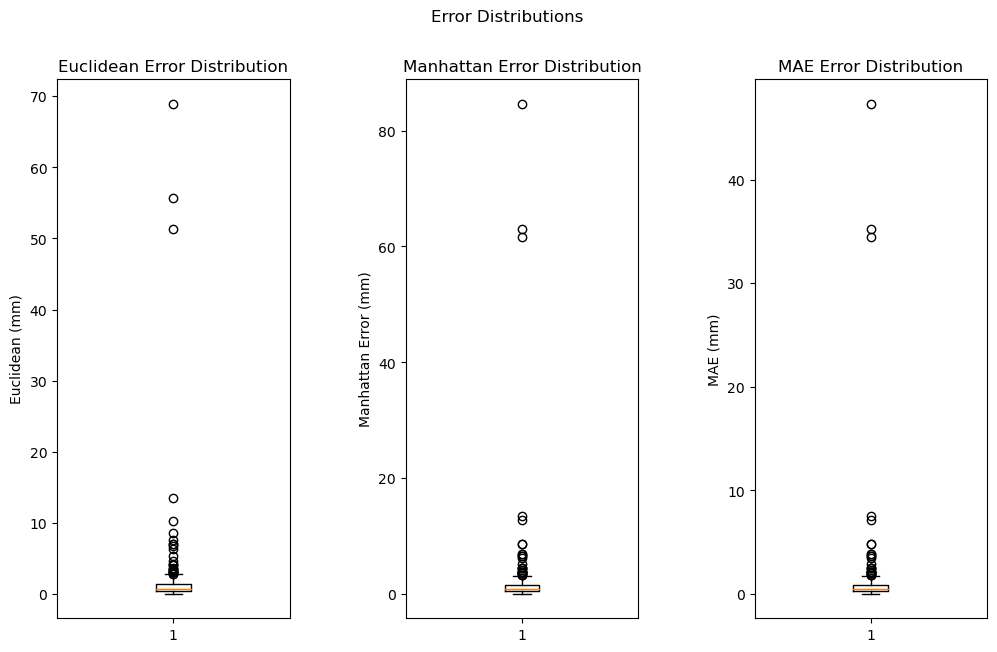

In [49]:
import matplotlib.pyplot as plt

# Create a figure with three subplots, one for each error metric
fig, axs = plt.subplots(1, 3, figsize=(12, 7))

# Create a box plot for MSE
axs[0].boxplot(df2['mse_error'])
axs[0].set_title('Euclidean Error Distribution')
axs[0].set_ylabel('Euclidean (mm)')

# Create a box plot for Manhattan error
axs[1].boxplot(df2['manhattan'])
axs[1].set_title('Manhattan Error Distribution')
axs[1].set_ylabel('Manhattan Error (mm)')

# Create a box plot for MAE
axs[2].boxplot(df2['mean_abs_error'])
axs[2].set_title('MAE Error Distribution')
axs[2].set_ylabel('MAE (mm)')

# Add a common title for the whole figure
fig.suptitle('Error Distributions')

# Adjust the spacing between subplots to avoid overlap
plt.subplots_adjust(wspace=0.5)

plt.show()